In [32]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

data = scipy.io.loadmat('data/assignmentImageDenoising_phantom.mat')

print("Keys in the loaded data:")
print(list(data.keys()))

Keys in the loaded data:
['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy']


In [33]:

image_noiseless = data['imageNoiseless']
image_noisy = data['imageNoisy']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (256, 256)
Noisy image shape: (256, 256)
Image data type: float64
Noiseless image range: [0.000, 1.000]
Noisy image range: [0.000, 1.198]


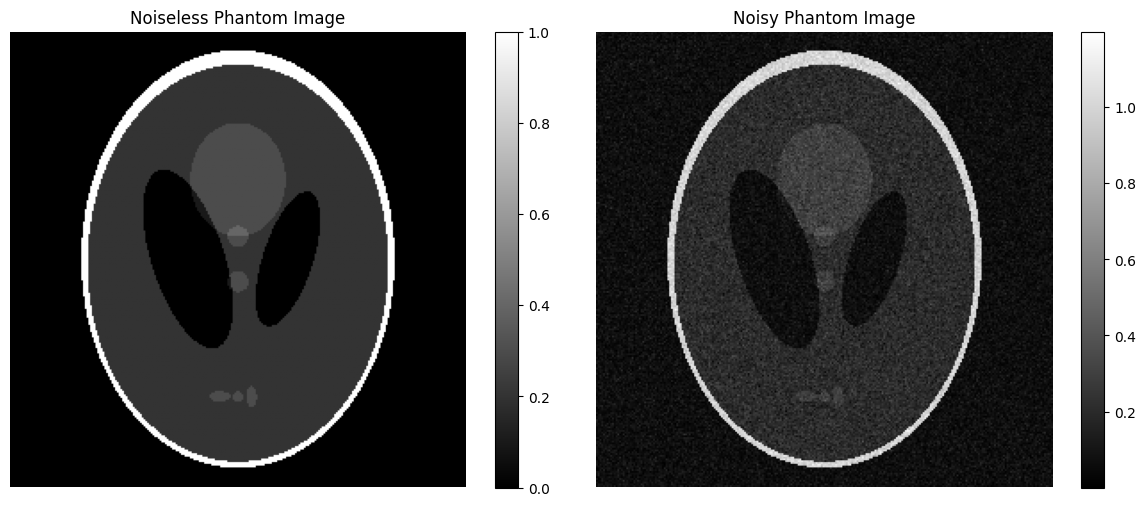

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Noiseless Phantom Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title('Noisy Phantom Image')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

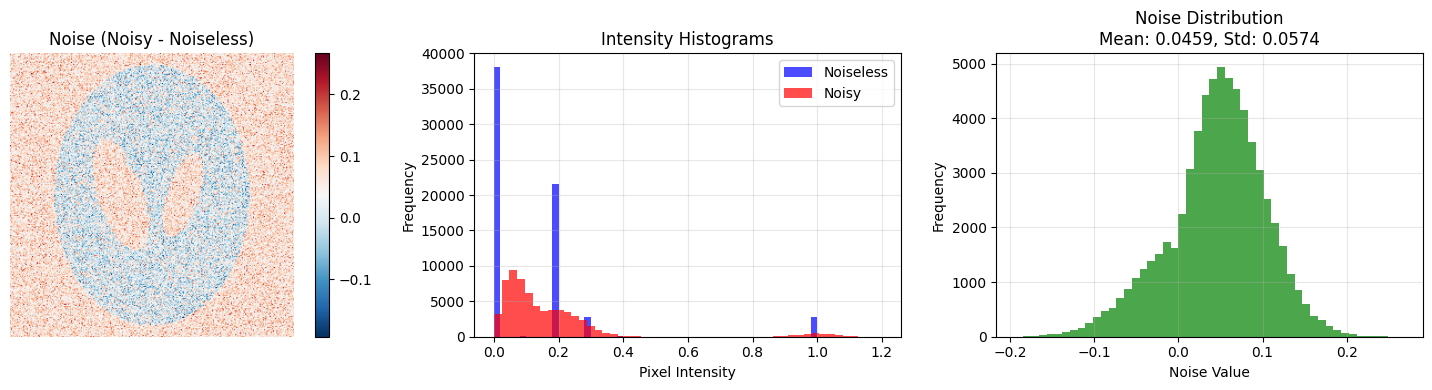

Summary Statistics:
Image size: (256, 256)
Noise standard deviation: 0.0574
Noise mean: 0.0459
Signal-to-Noise ratio (SNR): 11.40 dB


In [35]:
# Analyze the noise and show difference
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

plt.figure(figsize=(15, 4))

# Plot difference (noise)
plt.subplot(1, 3, 1)
plt.imshow(noise, cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)')
plt.colorbar()
plt.axis('off')

# Plot histogram of noiseless image
plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7, label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
plt.title('Intensity Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot noise histogram
plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(f"Image size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")
print(f"Signal-to-Noise ratio (SNR): {20 * np.log10(np.std(image_noiseless) / noise_std):.2f} dB")

# Bayesian Denoising with MRF Priors

This notebook implements a Maximum-A-Posteriori (MAP) Bayesian image denoising algorithm with Markov Random Field (MRF) priors using gradient ascent optimization.

In [36]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift(image, shift_vector):
    """
    Circular shift function similar to MATLAB's circshift
    """
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    return shifted

def compute_rrmse(A, B):
    """
    Compute Relative Root Mean Squared Error (RRMSE)
    RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    """
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

# MRF Prior Functions
def quadratic_prior(u):
    """
    Quadratic potential function: g1(u) = |u|^2
    """
    return u ** 2

def quadratic_prior_gradient(u):
    """
    Gradient of quadratic potential function: g1'(u) = 2u
    """
    return 2 * u

def huber_prior(u, gamma):
    """
    Discontinuity-adaptive Huber potential function:
    g2(u) = 0.5|u|^2 if |u| <= gamma
    g2(u) = gamma|u| - 0.5*gamma^2 if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma, 
                    0.5 * u ** 2,
                    gamma * abs_u - 0.5 * gamma ** 2)

def huber_prior_gradient(u, gamma):
    """
    Gradient of Huber potential function:
    g2'(u) = u if |u| <= gamma
    g2'(u) = gamma*sign(u) if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma,
                    u,
                    gamma * np.sign(u))

def discontinuity_preserving_prior(u, gamma):
    """
    Discontinuity-preserving potential function:
    g3(u) = gamma * |u| - gamma**2 * log(1 + |u|/gamma)
    """
    abs_u = np.abs(u)
    return gamma * abs_u - gamma**2 * np.log(1 + abs_u / gamma)

def discontinuity_preserving_prior_gradient(u, gamma):
    """
    Gradient of discontinuity-preserving potential function:
    g3'(u) = u / (1 + |u|/gamma)
    """
    return u / (1 + np.abs(u) / gamma)


print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [37]:
def compute_neighbor_differences(x):
    """
    Compute differences between each pixel and its 4 neighbors using circular shift
    Returns list of difference arrays [left, right, up, down]
    """
    # Neighbors: left, right, up, down
    left_neighbor = circshift(x, [0, -1])  # shift left by 1
    right_neighbor = circshift(x, [0, 1])  # shift right by 1
    up_neighbor = circshift(x, [-1, 0])   # shift up by 1
    down_neighbor = circshift(x, [1, 0])  # shift down by 1
    
    # Compute differences
    diff_left = x - left_neighbor
    diff_right = x - right_neighbor
    diff_up = x - up_neighbor
    diff_down = x - down_neighbor
    
    return [diff_left, diff_right, diff_up, diff_down]

def compute_mrf_energy(x, prior_func, gamma=None):
    """
    Compute MRF prior energy for an image
    """
    differences = compute_neighbor_differences(x)
    energy = 0
    
    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))
    
    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):
    """
    Compute gradient of MRF prior energy
    """
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)
    
    # For each neighbor direction
    for i, diff in enumerate(differences):
        if gamma is not None:
            grad_diff = prior_gradient_func(diff, gamma)
        else:
            grad_diff = prior_gradient_func(diff)
        
        # Add contribution from this neighbor
        gradient += grad_diff
        
        # Subtract contribution from being the neighbor (due to symmetry)
        if i == 0:  # left neighbor
            gradient -= circshift(grad_diff, [0, 1])
        elif i == 1:  # right neighbor
            gradient -= circshift(grad_diff, [0, -1])
        elif i == 2:  # up neighbor
            gradient -= circshift(grad_diff, [1, 0])
        elif i == 3:  # down neighbor
            gradient -= circshift(grad_diff, [-1, 0])
    
    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [38]:
def bayesian_denoising(noisy_image, alpha, prior_type='quadratic', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    """
    Bayesian MAP denoising with MRF priors using gradient ascent
    
    Parameters:
    - noisy_image: input noisy image
    - alpha: weighting parameter [0,1] (prior weight=alpha, likelihood weight=1-alpha)
    - prior_type: 'quadratic', 'huber', or 'discontinuity_preserving'
    - gamma: parameter for Huber and discontinuity-preserving priors
    - max_iterations: maximum number of iterations
    - tolerance: convergence tolerance
    - sigma: noise standard deviation (fixed at 1.0 as suggested)
    
    Returns:
    - denoised_image: final denoised image
    - objective_values: log posterior values at each iteration
    """
    
    # Initialize with noisy image
    x = noisy_image.copy()
    objective_values = []
    
    # Select prior functions
    if prior_type == 'quadratic':
        prior_func = quadratic_prior
        prior_grad_func = quadratic_prior_gradient
        use_gamma = False
    elif prior_type == 'huber':
        prior_func = huber_prior
        prior_grad_func = huber_prior_gradient
        use_gamma = True
    elif prior_type == 'discontinuity_preserving':
        prior_func = discontinuity_preserving_prior
        prior_grad_func = discontinuity_preserving_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'quadratic', 'huber', or 'discontinuity_preserving'")
    
    # Initial step size
    step_size = 0.1
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):
        # Compute log-likelihood gradient (Gaussian noise model)
        # L(x|y) = -1/(2*sigma^2) * ||x - y||^2
        # grad_L = (1/sigma^2) * (y - x)
        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        
        # Compute MRF prior gradient
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        
        # Combined gradient (note: we want to maximize log posterior)
        # grad_log_posterior = (1-alpha) * grad_likelihood - alpha * grad_prior
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        # Compute current objective value (log posterior)
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        # Adaptive step size using Armijo rule
        x_new, new_objective, accepted = simulated_annealing_step(x,total_gradient,current_objective,noisy_image,alpha,prior_func,gamma if use_gamma else None,sigma,step_size,temperature)
        # Update image
        x = x_new
        temperature *= cooling_rate        
        # Check convergence
        if iteration > 0:
            if objective_values[-1] - objective_values[-2] < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
            # Ensure objective is increasing
            if objective_values[-1] < objective_values[-2]:
                print(f"Warning: Objective decreased at iteration {iteration + 1}")
        
        x = x_new
        
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Objective = {current_objective:.6f}, Step size = {step_size:.6f}")
    
    return x, objective_values

def simulated_annealing_step(x,gradient,current_obj,noisy_image,alpha,prior_func,gamma,sigma,step,temperature):
    """
    One simulated annealing update step
    """

    # Propose a trial move
    x_trial = x + step * gradient

    # Compute trial objective
    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    # Objective difference
    delta_obj = trial_objective - current_obj

    # Acceptance rule
    if delta_obj >= 0:
        accept = True
    else:
        accept_prob = np.exp(delta_obj / temperature)
        accept = np.random.rand() < accept_prob

    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [39]:
# Test Quadratic Prior with different alpha values
print("Testing Quadratic Prior (g1(u) = |u|^2)")
print("=" * 50)

alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.995]
results_quadratic = {}

for alpha in alpha_values:
    print(f"\nTesting alpha = {alpha}")
    
    # Run denoising
    denoised, objectives = bayesian_denoising(
        image_noisy, alpha=alpha, prior_type='quadratic',
        max_iterations=100, tolerance=1e-6
    )
    
    # Compute RRMSE
    rrmse = compute_rrmse(image_noiseless, denoised)
    results_quadratic[alpha] = {
        'denoised': denoised,
        'rrmse': rrmse,
        'objectives': objectives
    }
    
    print(f"RRMSE: {rrmse:.6f}")

# Find best alpha for quadratic prior
best_alpha_quad = min(results_quadratic.keys(), key=lambda a: results_quadratic[a]['rrmse'])
best_rrmse_quad = results_quadratic[best_alpha_quad]['rrmse']
print(f"\nBest alpha for Quadratic prior: {best_alpha_quad} (RRMSE: {best_rrmse_quad:.6f})")

Testing Quadratic Prior (g1(u) = |u|^2)

Testing alpha = 0.001
Iteration 10: Objective = -3.582179, Step size = 0.100000
Iteration 20: Objective = -3.575364, Step size = 0.100000
Iteration 30: Objective = -3.574570, Step size = 0.100000
Iteration 40: Objective = -3.574478, Step size = 0.100000
Converged after 45 iterations
RRMSE: 0.296867

Testing alpha = 0.005
Iteration 10: Objective = -17.051552, Step size = 0.100000
Iteration 20: Objective = -16.913083, Step size = 0.100000
Iteration 30: Objective = -16.899420, Step size = 0.100000
Iteration 40: Objective = -16.898062, Step size = 0.100000
Iteration 50: Objective = -16.897926, Step size = 0.100000
Converged after 56 iterations
RRMSE: 0.291262

Testing alpha = 0.01
Iteration 10: Objective = -32.178883, Step size = 0.100000
Iteration 20: Objective = -31.747608, Step size = 0.100000
Iteration 30: Objective = -31.712296, Step size = 0.100000
Iteration 40: Objective = -31.709316, Step size = 0.100000
Iteration 50: Objective = -31.709056,

In [40]:
# Test Huber Prior with different alpha and gamma values
print("\nTesting Huber Prior")
print("=" * 50)

alpha_values = [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.9995]
gamma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 5, 10, 50]

results_huber = {}

best_rrmse = float('inf')
best_params = None

for alpha in alpha_values:
    for gamma in gamma_values:
        print(f"\nTesting alpha = {alpha}, gamma = {gamma}")
        
        # Run denoising
        denoised, objectives = bayesian_denoising(
            image_noisy, alpha=alpha, prior_type='huber', gamma=gamma,
            max_iterations=30, tolerance=1e-6
        )
        
        # Compute RRMSE
        rrmse = compute_rrmse(image_noiseless, denoised)
        results_huber[(alpha, gamma)] = {
            'denoised': denoised,
            'rrmse': rrmse,
            'objectives': objectives
        }
        
        print(f"RRMSE: {rrmse:.6f}")
        
        if rrmse < best_rrmse:
            best_rrmse = rrmse
            best_params = (alpha, gamma)

print(f"\nBest parameters for Huber prior: alpha={best_params[0]}, gamma={best_params[1]} (RRMSE: {best_rrmse:.6f})")


Testing Huber Prior

Testing alpha = 0.001, gamma = 0.01
Iteration 10: Objective = -0.151960, Step size = 0.100000
Converged after 16 iterations
RRMSE: 0.298488

Testing alpha = 0.001, gamma = 0.05
Iteration 10: Objective = -0.560035, Step size = 0.100000
Iteration 20: Objective = -0.559795, Step size = 0.100000
Converged after 30 iterations
RRMSE: 0.298093

Testing alpha = 0.001, gamma = 0.1
Iteration 10: Objective = -0.815323, Step size = 0.100000
Iteration 20: Objective = -0.814763, Step size = 0.100000
Iteration 30: Objective = -0.814696, Step size = 0.100000
RRMSE: 0.297813

Testing alpha = 0.001, gamma = 0.2
Iteration 10: Objective = -1.082280, Step size = 0.100000
Iteration 20: Objective = -1.081483, Step size = 0.100000
Iteration 30: Objective = -1.081388, Step size = 0.100000
RRMSE: 0.297681

Testing alpha = 0.001, gamma = 0.5
Iteration 10: Objective = -1.577001, Step size = 0.100000
Iteration 20: Objective = -1.575914, Step size = 0.100000
Iteration 30: Objective = -1.575784

In [41]:
# Test Discontinuity-preserving Prior with different alpha and gamma values
print("\nTesting Discontinuity-preserving Prior")
print("=" * 50)

alpha_values = [0.001, 0.005, 0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.995, 0.9995]
gamma_values = [0.01, 0.03, 0.05, 0.1, 0.2]

results_disc = {}

best_rrmse_disc = float('inf')
best_params_disc = None

for alpha in alpha_values:
    for gamma in gamma_values:
        print(f"\nTesting alpha = {alpha}, gamma = {gamma}")
        
        # Run denoising
        denoised, objectives = bayesian_denoising(
            image_noisy, alpha=alpha, prior_type='discontinuity_preserving', gamma=gamma,
            max_iterations=30, tolerance=1e-6
        )
        
        # Compute RRMSE
        rrmse = compute_rrmse(image_noiseless, denoised)
        results_disc[(alpha, gamma)] = {
            'denoised': denoised,
            'rrmse': rrmse,
            'objectives': objectives
        }
        
        print(f"RRMSE: {rrmse:.6f}")
        
        if rrmse < best_rrmse_disc:
            best_rrmse_disc = rrmse
            best_params_disc = (alpha, gamma)

print(f"\nBest parameters for Discontinuity-preserving prior: alpha={best_params_disc[0]}, gamma={best_params_disc[1]} (RRMSE: {best_rrmse_disc:.6f})")


Testing Discontinuity-preserving Prior

Testing alpha = 0.001, gamma = 0.01
Iteration 10: Objective = -0.121559, Step size = 0.100000
Converged after 15 iterations
RRMSE: 0.298503

Testing alpha = 0.001, gamma = 0.03
Iteration 10: Objective = -0.275076, Step size = 0.100000
Iteration 20: Objective = -0.275026, Step size = 0.100000
Converged after 23 iterations
RRMSE: 0.298368

Testing alpha = 0.001, gamma = 0.05
Iteration 10: Objective = -0.381619, Step size = 0.100000
Iteration 20: Objective = -0.381522, Step size = 0.100000
Converged after 26 iterations
RRMSE: 0.298275

Testing alpha = 0.001, gamma = 0.1
Iteration 10: Objective = -0.562867, Step size = 0.100000
Iteration 20: Objective = -0.562662, Step size = 0.100000
Converged after 29 iterations
RRMSE: 0.298128

Testing alpha = 0.001, gamma = 0.2
Iteration 10: Objective = -0.781049, Step size = 0.100000
Iteration 20: Objective = -0.780683, Step size = 0.100000
Iteration 30: Objective = -0.780638, Step size = 0.100000
RRMSE: 0.2979

In [42]:
# Generate final results with optimal parameters
print("Final Optimization with Best Parameters")
print("=" * 50)

# Run final denoising with optimal parameters and more iterations
final_results = {}

# 1. Quadratic prior with best alpha
print("\\nFinal run - Quadratic Prior:")
denoised_quad_final, obj_quad_final = bayesian_denoising(
    image_noisy, alpha=best_alpha_quad, prior_type='quadratic',
    max_iterations=100, tolerance=1e-7
)
rrmse_quad_final = compute_rrmse(image_noiseless, denoised_quad_final)
final_results['quadratic'] = {
    'denoised': denoised_quad_final,
    'rrmse': rrmse_quad_final,
    'alpha': best_alpha_quad,
    'gamma': None
}
print(f"Quadratic - Alpha: {best_alpha_quad}, RRMSE: {rrmse_quad_final:.6f}")

# 2. Huber prior with best parameters (from previous results)
print("\\nFinal run - Huber Prior:")
# Find best from results_huber
best_huber_key = min(results_huber.keys(), key=lambda k: results_huber[k]['rrmse'])
best_alpha_huber, best_gamma_huber = best_huber_key
denoised_huber_final, obj_huber_final = bayesian_denoising(
    image_noisy, alpha=best_alpha_huber, prior_type='huber', gamma=best_gamma_huber,
    max_iterations=100, tolerance=1e-7
)
rrmse_huber_final = compute_rrmse(image_noiseless, denoised_huber_final)
final_results['huber'] = {
    'denoised': denoised_huber_final,
    'rrmse': rrmse_huber_final,
    'alpha': best_alpha_huber,
    'gamma': best_gamma_huber
}
print(f"Huber - Alpha: {best_alpha_huber}, Gamma: {best_gamma_huber}, RRMSE: {rrmse_huber_final:.6f}")

# 3. Discontinuity-preserving prior with best parameters
print("\\nFinal run - Discontinuity-preserving Prior:")
best_disc_key = min(results_disc.keys(), key=lambda k: results_disc[k]['rrmse'])
best_alpha_disc, best_gamma_disc = best_disc_key
denoised_disc_final, obj_disc_final = bayesian_denoising(
    image_noisy, alpha=best_alpha_disc, prior_type='discontinuity_preserving', gamma=best_gamma_disc,
    max_iterations=100, tolerance=1e-7
)
rrmse_disc_final = compute_rrmse(image_noiseless, denoised_disc_final)
final_results['discontinuity_preserving'] = {
    'denoised': denoised_disc_final,
    'rrmse': rrmse_disc_final,
    'alpha': best_alpha_disc,
    'gamma': best_gamma_disc
}
print(f"Discontinuity-preserving - Alpha: {best_alpha_disc}, Gamma: {best_gamma_disc}, RRMSE: {rrmse_disc_final:.6f}")

print("\\n" + "=" * 50)
print("FINAL COMPARISON:")
for method, result in final_results.items():
    print(f"{method.capitalize()}: RRMSE = {result['rrmse']:.6f}")

# Find overall best method
best_method = min(final_results.keys(), key=lambda m: final_results[m]['rrmse'])
print(f"\\nBEST METHOD: {best_method.upper()} with RRMSE = {final_results[best_method]['rrmse']:.6f}")

Final Optimization with Best Parameters
\nFinal run - Quadratic Prior:
Iteration 10: Objective = -112.233291, Step size = 0.100000
Iteration 20: Objective = -110.097669, Step size = 0.100000
Iteration 30: Objective = -110.003820, Step size = 0.100000
Iteration 40: Objective = -109.997244, Step size = 0.100000
Iteration 50: Objective = -109.996672, Step size = 0.100000
Iteration 60: Objective = -109.996617, Step size = 0.100000
Iteration 70: Objective = -109.996612, Step size = 0.100000
Converged after 73 iterations
Quadratic - Alpha: 0.05, RRMSE: 0.285314
\nFinal run - Huber Prior:
Iteration 10: Objective = -55.238040, Step size = 0.100000
Iteration 20: Objective = -39.503688, Step size = 0.100000
Iteration 30: Objective = -36.820138, Step size = 0.100000
Iteration 40: Objective = -36.311908, Step size = 0.100000
Iteration 50: Objective = -36.162407, Step size = 0.100000
Iteration 60: Objective = -36.093312, Step size = 0.100000
Iteration 70: Objective = -36.054256, Step size = 0.10000

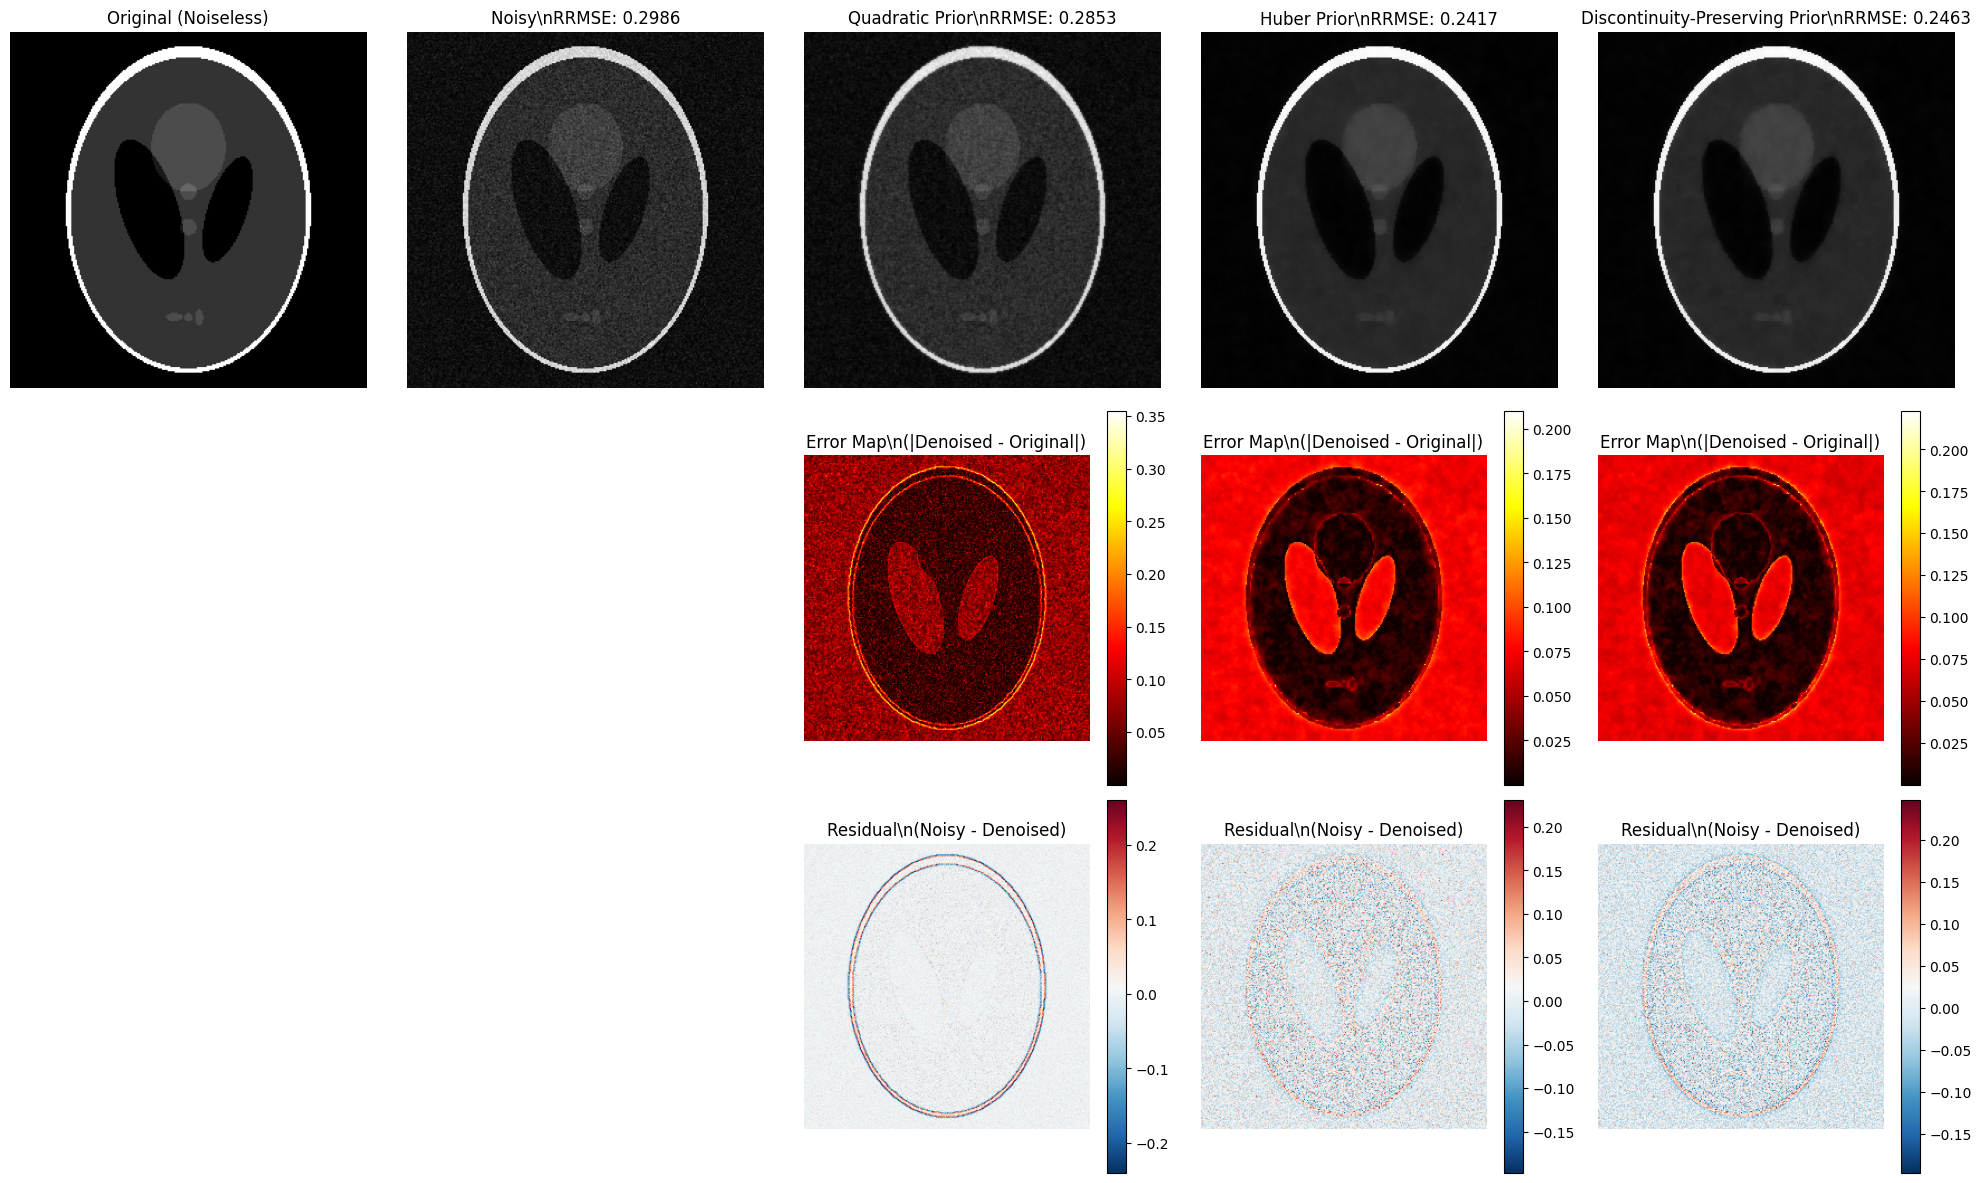

\nDetailed Parameter Summary:
\nQUADRATIC:
  α (alpha): 0.05
  RRMSE: 0.285314
  MSE: 0.004936
  PSNR: 23.07 dB
\nHUBER:
  α (alpha): 0.8
  γ (gamma): 0.01
  RRMSE: 0.241718
  MSE: 0.003543
  PSNR: 24.51 dB
\nDISCONTINUITY_PRESERVING:
  α (alpha): 0.85
  γ (gamma): 0.01
  RRMSE: 0.246271
  MSE: 0.003678
  PSNR: 24.34 dB


In [43]:
# Visualize final results
plt.figure(figsize=(20, 12))

# Original images
plt.subplot(3, 5, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Original (Noiseless)')
plt.axis('off')

plt.subplot(3, 5, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f'Noisy\\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}')
plt.axis('off')

# Denoised results
methods = ['quadratic', 'huber', 'discontinuity_preserving']
titles = ['Quadratic Prior', 'Huber Prior', 'Discontinuity-Preserving Prior']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]
    
    # Denoised image
    plt.subplot(3, 5, 3 + i)
    plt.imshow(result['denoised'], cmap='gray')
    plt.title(f'{title}\\nRRMSE: {result["rrmse"]:.4f}')
    plt.axis('off')
    
    # Error map (difference from ground truth)
    plt.subplot(3, 5, 8 + i)
    error = np.abs(result['denoised'] - image_noiseless)
    plt.imshow(error, cmap='hot')
    plt.title(f'Error Map\\n(|Denoised - Original|)')
    plt.colorbar()
    plt.axis('off')
    
    # Residual (difference from noisy)
    plt.subplot(3, 5, 13 + i)
    residual = image_noisy - result['denoised']
    plt.imshow(residual, cmap='RdBu_r')
    plt.title(f'Residual\\n(Noisy - Denoised)')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\\nDetailed Parameter Summary:")
print("=" * 60)
for method, result in final_results.items():
    print(f"\\n{method.upper()}:")
    print(f"  α (alpha): {result['alpha']}")
    if result['gamma'] is not None:
        print(f"  γ (gamma): {result['gamma']}")
    print(f"  RRMSE: {result['rrmse']:.6f}")
    
    # Compute additional metrics
    mse = np.mean((result['denoised'] - image_noiseless)**2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # Assuming image range [0,1]
    print(f"  MSE: {mse:.6f}")
    print(f"  PSNR: {psnr:.2f} dB")